In [5]:
from pyspark.sql import SparkSession

import numpy as np
import pandas as pd
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import countDistinct, avg, stddev

import time
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
spark = SparkSession.builder.appName('question2').getOrCreate()
new = spark.read.csv('insurance.csv', header=True, inferSchema=True)

### Data Exploration

In [7]:
new.show(6)

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
+---+------+------+--------+------+---------+-----------+
only showing top 6 rows



In [8]:
new.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [9]:
new.columns

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [10]:
len(new.columns)

7

In [11]:
new.describe().show()

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.663396860986538|  1.0949177877429|  null|     null|13270.422265141257|
| stddev|14.049960379216147|  null| 6.098186911679012|1.205492739781914|  null|     null|12110.011236693992|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+



In [12]:
new.groupby('sex').count().show()

+------+-----+
|   sex|count|
+------+-----+
|female|  662|
|  male|  676|
+------+-----+



+------+-----+
|smoker|count|
+------+-----+
|    no| 1064|
|   yes|  274|
+------+-----+



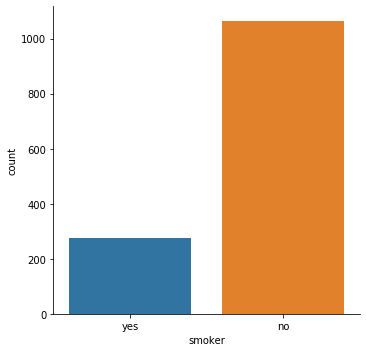

In [13]:
new.groupby('smoker').count().show()
abc = new.toPandas()
sns.catplot(x='smoker', kind='count', data=abc)

+--------+-----+
|children|count|
+--------+-----+
|       1|  324|
|       3|  157|
|       5|   18|
|       4|   25|
|       2|  240|
|       0|  574|
+--------+-----+



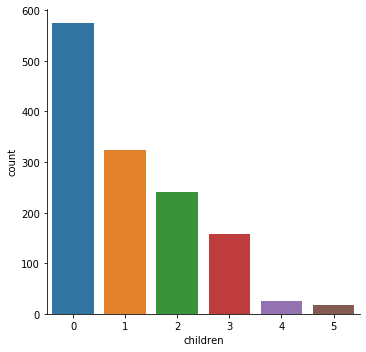

In [14]:
new.groupby('children').count().show()
sns.catplot(x='children', kind='count', data=abc)

BMI less than 25: 247
BMI greater than 25: 1091


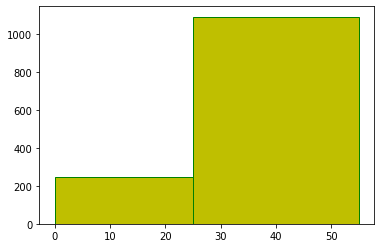

In [15]:
ef=0
gh=0
for i in abc['bmi']:
    if (i<=25):
        ef+=1
    else:
        gh+=1
print('BMI less than 25:', ef)
print('BMI greater than 25:', gh)
plt.hist(abc.bmi, bins=[0,25,55],facecolor='y', edgecolor='green')
plt.show()

Text(0.5, 1, 'Age Vs Charges')

<Figure size 864x576 with 0 Axes>

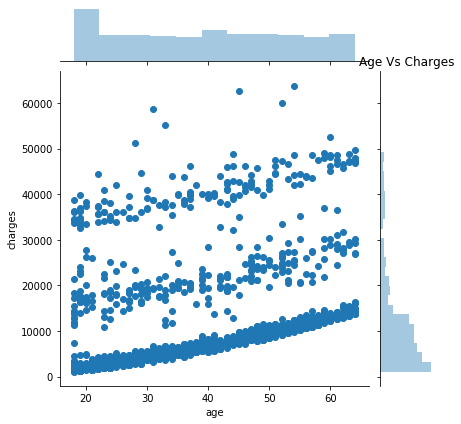

In [16]:
plt.figure(figsize=(12,8))
sns.jointplot(x='age',y='charges', data=abc)
plt.title('Age Vs Charges')

charges for people who has 3 or less than 3 children: 11730.582377441857
 charges for more than 3 children: 13321.552083806173


Text(0.5, 1.0, 'No. of Children Vs Charges')

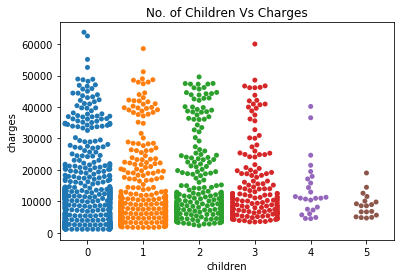

In [19]:
mean_chl,mean_chm = abc['charges'][abc['children'] > 3].mean(), abc['charges'][abc['children'] <= 3].mean()
print("charges for people who has 3 or less than 3 children:",mean_chl)
print(" charges for more than 3 children:",mean_chm)
sns.swarmplot(x='children',y='charges', data=abc)
plt.title('No. of Children Vs Charges')

In [21]:
new.corr('age','charges')

0.299008193330648

In [22]:
new.groupBy("children").max().show()

+--------+--------+--------+-------------+------------+
|children|max(age)|max(bmi)|max(children)|max(charges)|
+--------+--------+--------+-------------+------------+
|       1|      64|   52.58|            1| 58571.07448|
|       3|      64|   46.53|            3| 60021.39897|
|       5|      52|   46.75|            5|    19023.26|
|       4|      61|   41.47|            4|   40182.246|
|       2|      64|   48.07|            2|  49577.6624|
|       0|      64|   53.13|            0| 63770.42801|
+--------+--------+--------+-------------+------------+



In [24]:
new.orderBy(new['charges'].desc()).show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 54|female| 47.41|       0|   yes|southeast|63770.42801|
| 45|  male| 30.36|       0|   yes|southeast|62592.87309|
| 52|  male|34.485|       3|   yes|northwest|60021.39897|
| 31|female|38.095|       1|   yes|northeast|58571.07448|
| 33|female| 35.53|       0|   yes|northwest|55135.40209|
| 60|  male|  32.8|       0|   yes|southwest|52590.82939|
| 28|  male|  36.4|       1|   yes|southwest|51194.55914|
| 64|  male| 36.96|       2|   yes|southeast| 49577.6624|
| 59|  male| 41.14|       1|   yes|southeast| 48970.2476|
| 44|female| 38.06|       0|   yes|southeast|48885.13561|
| 63|female|  37.7|       0|   yes|southwest|   48824.45|
| 57|  male| 42.13|       1|   yes|southeast| 48675.5177|
| 60|  male| 40.92|       0|   yes|southeast| 48673.5588|
| 54|  male|40.565|       3|   yes|northeast|48549.17835|
| 61|female|36

### Feature Engineering

In [25]:
from pyspark.sql.functions import isnan, when, count, col
def get_null_value_count(data):
    data.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in data.columns]).show()

In [27]:
get_null_value_count(new)

+---+---+---+--------+------+------+-------+
|age|sex|bmi|children|smoker|region|charges|
+---+---+---+--------+------+------+-------+
|  0|  0|  0|       0|     0|     0|      0|
+---+---+---+--------+------+------+-------+



In [29]:
cat_cols = [c[0] for c in new.dtypes if c[1]=='string']
cat_cols

['sex', 'smoker', 'region']

In [30]:
num_cols = [c[0] for c in new.dtypes if c[1]!='string']
num_cols = num_cols[0:3]
num_cols

['age', 'bmi', 'children']

In [31]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
stages=[]
for cat_col in cat_cols:
    stringIndexer = StringIndexer(inputCol = cat_col, outputCol = cat_col + '_Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()],outputCols = [cat_col +'_OHE'])
    stages += [stringIndexer, encoder]
assemblerInputs = [c + '_OHE' for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='asv_features')
stages += [assembler]
ss = StandardScaler(inputCol='asv_features', outputCol='features')
stages += [ss]

In [33]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(new)
df_pipetrans = pipelineModel.transform(new)
df_trans = df_pipetrans.select('features','charges')

In [34]:
df_trans = df_trans.withColumnRenamed('charges','label')

In [35]:
train_data, test_data = df_trans.randomSplit([0.7,0.3], seed = 1234)

In [36]:
from pyspark.ml.regression import LinearRegression
lm = LinearRegression(featuresCol='features',labelCol='label')
lm_model = lm.fit(train_data)

In [37]:
trainSummary=lm_model.summary
print("MAE: ", trainSummary.meanAbsoluteError)
print("MSE: ", trainSummary.meanSquaredError)
print("RMSE: ", trainSummary.rootMeanSquaredError)
print("R2: ", trainSummary.r2)

MAE:  4156.93024116977
MSE:  35294045.11896927
RMSE:  5940.879153708588
R2:  0.7514985778969564


In [38]:
lm_predictions = lm_model.transform(test_data)
lm_predictions.select('features','prediction','label').show(5)

+--------------------+-------------------+----------+
|            features|         prediction|     label|
+--------------------+-------------------+----------+
|(8,[0,1,5,6],[1.9...|-2231.7923860140763| 1694.7964|
|(8,[0,1,5,6],[1.9...| -305.2379873113532| 1702.4553|
|(8,[0,1,5,6],[1.9...|  491.9569362897746| 1705.6245|
|(8,[0,1,5,6],[1.9...|  7204.609924282191|3268.84665|
|(8,[0,1,5,6],[1.9...|  8451.691516250417|12404.8791|
+--------------------+-------------------+----------+
only showing top 5 rows



In [39]:
from pyspark.ml.evaluation import RegressionEvaluator
lm_evaluator = RegressionEvaluator(predictionCol = 'prediction',labelCol='label',metricName='r2')
print("R Squared on test data: ", lm_evaluator.evaluate(lm_predictions))

R Squared on test data:  0.7470182227409288


In [40]:
# Displaying metrics of the model over test data
res = lm_model.evaluate(test_data)
print("MAE: ", res.meanAbsoluteError)
print("MSE: ", res.meanSquaredError)
print("RMSE: ", res.rootMeanSquaredError)
print("R2: ", res.r2)

MAE:  4294.353080248329
MSE:  39767469.09471185
RMSE:  6306.1453436082365
R2:  0.7470182227409288
